In [1]:
import pymongo
import pandas as pd
import numpy as np
import math
from datetime import datetime

# import dask.dataframe as dd ## 대규모 데이터 처리
# import vaex ## 대규모 데이터 처리

# from sklearn.linear_model import LinearRegression ## likes, dislikes 대체
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import os
from dotenv import load_dotenv

In [2]:
file_path = 'C:/py_src/awake/data/'

In [3]:
# 계정 / 콘텐츠 분석 데이터셋 불러오기
merge_df_users_fin = pd.read_csv(file_path + 'merge_df_users_fin.csv', low_memory=False)
youtube_videos = pd.read_csv(file_path + 'youtube_videos.csv')

## 계정 데이터 분석

### 기초통계

In [4]:
# 기초통계
merge_df_users_fin[merge_df_users_fin.columns[11:-16]].describe()

,views,redViews,UNSUBSCRIBED,SUBSCRIBED,comments,likes,shares,dislikes,estimatedMinutesWatched,averageViewDuration,averageViewPercentage,estimated_revenue,estimated_ad_revenue,estimated_red_partner_revenue,gross_revenue,cpm,playback_based_cpm,subscribers_count,subscribers_gained,subscribers_lost
count,1.056830e+05,1.056830e+05,1.056830e+05,1.056830e+05,105683.000000,1.056830e+05,105683.000000,105683.000000,1.056830e+05,105683.000000,105683.000000,1.056830e+05,1.056830e+05,105683.000000,1.056830e+05,105683.000000,105683.000000,1.056830e+05,105683.000000,105683.000000
mean,7.669704e+04,1.181762e+04,5.780240e+04,8.794060e+03,36.601629,3.968254e+03,122.175610,38.654117,8.683548e+04,2.590939,35.047682,2.877474e+04,1.501653e+04,3248.437925,2.722400e+04,5030.826465,5499.273283,6.988129e+04,125.901574,41.760690
std,9.172899e+05,6.232938e+04,7.977084e+05,1.190782e+05,326.696229,7.623700e+04,1486.124555,462.391495,8.077970e+05,6.506950,55.212625,1.318711e+05,6.781683e+04,13148.516236,1.231992e+05,22890.346092,6556.226151,1.789418e+05,1278.900197,348.199082
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.755000e+03,0.000000,-426.000000,0.000000e+00,0.000000,0.000000,-1.127185e+06,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,3.290000e+02,8.700000e+01,9.100000e+01,3.000000e+00,0.000000,2.000000e+00,1.000000,0.000000,5.450000e+02,0.780000,16.680000,1.175040e+02,4.842900e+01,8.373500,8.782450e+01,24.000000,3232.250500,3.530000e+03,1.000000,1.000000
50%,1.844000e+03,4.900000e+02,9.020000e+02,7.600000e+01,1.000000,2.000000e+01,6.000000,1.000000,2.694000e+03,1.580000,28.000000,1.480631e+03,8.320230e+02,132.648000,1.504621e+03,328.000000,5155.512000,1.506600e+04,8.000000,5.000000
75%,1.212200e+04,3.405500e+03,6.649500e+03,8.305000e+02,9.000000,1.620000e+02,33.000000,5.000000,2.045400e+04,2.580000,47.680000,1.108485e+04,5.085199e+03,1021.478500,9.190117e+03,2119.000000,7229.389500,5.203100e+04,43.000000,22.000000
max,4.064898e+07,1.862117e+06,3.707229e+07,4.546611e+06,35931.000000,3.054524e+06,64529.000000,24353.000000,3.330760e+07,120.230000,15049.760000,5.338431e+06,3.082096e+06,388432.785000,5.601879e+06,994860.000000,489556.625000,3.442657e+06,77446.000000,18821.000000


In [5]:
# 잘못된값 처리
merge_df_users_fin['estimated_revenue'] = np.where(merge_df_users_fin['estimated_revenue'] < 0,
                                                   merge_df_users_fin['estimated_ad_revenue'] + merge_df_users_fin['estimated_red_partner_revenue'],
                                                   merge_df_users_fin['estimated_revenue'])

### 상관관계

In [6]:
# 상관관계
users_corr_matrix = merge_df_users_fin[merge_df_users_fin.columns[11:-16]].corr()
users_corr_matrix

,views,redViews,UNSUBSCRIBED,SUBSCRIBED,comments,likes,shares,dislikes,estimatedMinutesWatched,averageViewDuration,averageViewPercentage,estimated_revenue,estimated_ad_revenue,estimated_red_partner_revenue,gross_revenue,cpm,playback_based_cpm,subscribers_count,subscribers_gained,subscribers_lost
views,1.000000,0.887237,0.990442,0.943630,0.513510,0.989553,0.977800,0.988343,0.977856,-0.018855,0.037667,0.707427,0.527626,0.564268,0.528796,0.512862,0.015210,0.476780,0.945025,0.957050
redViews,0.887237,1.000000,0.852712,0.829370,0.505902,0.830601,0.835948,0.870122,0.871829,-0.036296,0.070093,0.746953,0.569576,0.670893,0.570658,0.574717,0.007111,0.567356,0.807065,0.830827
UNSUBSCRIBED,0.990442,0.852712,1.000000,0.936746,0.490312,0.985804,0.972716,0.976795,0.967478,-0.016759,0.044962,0.677054,0.511655,0.537700,0.512832,0.498079,0.015871,0.457118,0.947833,0.953924
SUBSCRIBED,0.943630,0.829370,0.936746,1.000000,0.529463,0.950954,0.921654,0.925751,0.945687,-0.011540,0.037588,0.769096,0.591106,0.603220,0.592372,0.569441,0.028896,0.535358,0.840056,0.905884
comments,0.513510,0.505902,0.490312,0.529463,1.000000,0.500979,0.497708,0.524899,0.503878,-0.019573,0.043904,0.439432,0.325125,0.350781,0.325862,0.323164,0.007777,0.312102,0.504283,0.524476
likes,0.989553,0.830601,0.985804,0.950954,0.500979,1.000000,0.984213,0.977959,0.970689,-0.013458,0.027295,0.680034,0.505728,0.524644,0.506934,0.484658,0.018521,0.441308,0.936573,0.951134
shares,0.977800,0.835948,0.972716,0.921654,0.497708,0.984213,1.000000,0.967875,0.964019,-0.006929,0.028528,0.686037,0.529940,0.542907,0.530864,0.506659,0.024675,0.447388,0.938846,0.945531
dislikes,0.988343,0.870122,0.976795,0.925751,0.524899,0.977959,0.967875,1.000000,0.962861,-0.020414,0.037492,0.692621,0.500523,0.548045,0.501676,0.484593,0.012684,0.452646,0.958289,0.962212
estimatedMinutesWatched,0.977856,0.871829,0.967478,0.945687,0.503878,0.970689,0.964019,0.962861,1.000000,0.082526,0.026288,0.788171,0.657877,0.669697,0.658758,0.630532,0.033969,0.524253,0.912208,0.939512
averageViewDuration,-0.018855,-0.036296,-0.016759,-0.011540,-0.019573,-0.013458,-0.006929,-0.020414,0.082526,1.000000,-0.042992,0.105156,0.146358,0.365298,0.145600,0.099347,0.078650,0.030085,-0.015928,-0.015658


In [7]:
# 버그로 사용된 수치값 대체
merge_df_users_fin['likes'] = np.where(merge_df_users_fin['likes'] < 0, 0, merge_df_users_fin['likes'])
merge_df_users_fin['dislikes'] = np.where(merge_df_users_fin['dislikes'] < 0, 0, merge_df_users_fin['dislikes'])

### 파생변수

In [8]:
# 파생변수1 - 참여도 관련
merge_df_users_fin['like_rate'] = merge_df_users_fin['likes'] / merge_df_users_fin['views'] ## 좋아요 비율 
merge_df_users_fin['comment_rate'] = merge_df_users_fin['comments'] / merge_df_users_fin['views'] ## 댓글 비율
merge_df_users_fin['share_rate'] = merge_df_users_fin['shares'] / merge_df_users_fin['views'] ## 공유 비율  
merge_df_users_fin['dislike_rate'] = merge_df_users_fin['dislikes'] / merge_df_users_fin['views'] ## 싫어요 비율
merge_df_users_fin['total_engage_rate'] = (merge_df_users_fin['likes'] + merge_df_users_fin['comments'] + merge_df_users_fin['shares'] + merge_df_users_fin['dislikes']) / merge_df_users_fin['views'] ## 총 참여율
merge_df_users_fin['positive_engage_rate'] = (merge_df_users_fin['likes'] + merge_df_users_fin['shares']) / merge_df_users_fin['views'] ## 긍정적 참여율
merge_df_users_fin['comment_to_like_rate'] = merge_df_users_fin['comments'] / merge_df_users_fin['likes'] ## 댓글/좋아요 비율
merge_df_users_fin['like_to_dislike_ratio'] = merge_df_users_fin['likes'] / (merge_df_users_fin['dislikes']) ## 좋아요/싫어요 비율

In [9]:
# 파생변수2 - 구독자 관련
merge_df_users_fin['subscriber_increase_rate'] = merge_df_users_fin['subscribers_gained'] / merge_df_users_fin['subscribers_count'] ## 구독자 증가율
merge_df_users_fin['subscriber_decrease_rate'] = merge_df_users_fin['subscribers_lost'] / merge_df_users_fin['subscribers_count'] ## 구독자 감소율
merge_df_users_fin['net_subscribers_change'] = merge_df_users_fin['subscribers_gained'] - merge_df_users_fin['subscribers_lost'] ## 구독자 순증가
merge_df_users_fin['subscribers_conversion_rate'] = merge_df_users_fin['subscribers_gained'] / merge_df_users_fin['views'] ## 구독자 전환율
merge_df_users_fin['subscriber_retention_rate'] = (merge_df_users_fin['SUBSCRIBED'] - merge_df_users_fin['UNSUBSCRIBED']) / merge_df_users_fin['subscribers_count'] ## 구독자 유지율
merge_df_users_fin['subscribed_view_rate'] = merge_df_users_fin['SUBSCRIBED'] / (merge_df_users_fin['SUBSCRIBED'] + merge_df_users_fin['UNSUBSCRIBED']) ## 구독자 조회수 비율
merge_df_users_fin['unsubscribed_view_rate'] = merge_df_users_fin['UNSUBSCRIBED'] / (merge_df_users_fin['SUBSCRIBED'] + merge_df_users_fin['UNSUBSCRIBED']) ## 비구독자 조회수 비율

In [10]:
# 파생변수3 - 수익 관련
merge_df_users_fin['revenue_per_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['views'] ## 조회수당 수익
merge_df_users_fin['revenue_per_subscribed_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['SUBSCRIBED'] ## 구독자조회수당 수익
merge_df_users_fin['revenue_per_unsubscribed_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['UNSUBSCRIBED'] ## 비구독자조회수당 수익
merge_df_users_fin['revenue_per_subscriber'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['subscribers_count'] ## 구독자당 수익
merge_df_users_fin['revenue_per_red_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['redViews'] ## 프리미엄당 수익
merge_df_users_fin['ad_revenue_rate'] = merge_df_users_fin['estimated_ad_revenue'] / merge_df_users_fin['estimated_revenue'] ## 광고수익비율
merge_df_users_fin['red_revenue_rate'] = merge_df_users_fin['estimated_red_partner_revenue'] / merge_df_users_fin['estimated_revenue'] ## 프리미엄수익비율
merge_df_users_fin['cpm_to_revenue_ratio'] = merge_df_users_fin['cpm'] / merge_df_users_fin['estimated_revenue'] ## cpm 대비 수익
merge_df_users_fin['revenue_per_ad_impression'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['ad_impressions'] ## 광고노출당 수익
merge_df_users_fin['playback_based_cpm_rate'] = merge_df_users_fin['playback_based_cpm'] / merge_df_users_fin['cpm'] ## 재생 기반 수익

In [11]:
# 파생변수4 - 시청 시간 관련
merge_df_users_fin['revenue_per_minute_watched'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['estimatedMinutesWatched'] ## 시청 시간 당 수익
merge_df_users_fin['avg_view_duration_rate'] = merge_df_users_fin['averageViewDuration'] / merge_df_users_fin['averageViewPercentage'] ## 평균 시청 시간 비율
merge_df_users_fin['watched_time_rate'] = merge_df_users_fin['averageViewPercentage'] * merge_df_users_fin['estimatedMinutesWatched'] ## 재생 비율 대비 시청 시간
merge_df_users_fin['watched_view_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['views'] ## 조회수당 시청시간
merge_df_users_fin['subscribed_view_time_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['SUBSCRIBED'] ## 구독자조회수당 시청시간
merge_df_users_fin['unsubscribed_view_time_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['UNSUBSCRIBED'] ## 비구독자조회수당 시청시간
merge_df_users_fin['subscriber_view_time_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['subscribers_count'] ## 구독자당 시청시간

In [12]:
# 파생변수5 - 광고 관련
merge_df_users_fin['revenue_per_playback'] = merge_df_users_fin['gross_revenue'] / merge_df_users_fin['monetized_playbacks'] ## 1회 광고재생당 수익
merge_df_users_fin['gross_revenue_per_ad_impression'] = merge_df_users_fin['gross_revenue'] / merge_df_users_fin['ad_impressions'] ## 1회 광고노출당 총수익
merge_df_users_fin['playback_rate'] = merge_df_users_fin['monetized_playbacks'] / merge_df_users_fin['ad_impressions'] ## 광고노출 대비 재생율
merge_df_users_fin['unplayback_rate'] = (merge_df_users_fin['ad_impressions'] - merge_df_users_fin['monetized_playbacks']) / merge_df_users_fin['ad_impressions'] ## 광고노출 대비 비재생율

In [13]:
# 파생변수6 - 연령 및 성별 관련
female_col = [col_nm for col_nm in merge_df_users_fin.columns if 'female' in col_nm ]
male_col = [col_nm for col_nm in merge_df_users_fin.columns if ('male' in col_nm) and ('female' not in col_nm)]

youth_col = [col_nm for col_nm in merge_df_users_fin.columns if '13-17' in col_nm]
adult_col = [col_nm for col_nm in merge_df_users_fin.columns if ('18-24' in col_nm) or ('25-34' in col_nm) or ('35-44' in col_nm) or ('45-54' in col_nm)]
older_col = [col_nm for col_nm in merge_df_users_fin.columns if ('55-64' in col_nm) or ('65' in col_nm)]

merge_df_users_fin['female_viewer_rate'] = merge_df_users_fin[female_col].sum(axis=1) ## 여성 시청자 비율
merge_df_users_fin['male_viewer_rate'] = merge_df_users_fin[male_col].sum(axis=1) ## 남성 시청자 비율

merge_df_users_fin['youth_viewer_rate'] = merge_df_users_fin[youth_col].sum(axis=1) ## 청소년 시청자 비율
merge_df_users_fin['adult_viewer_rate'] = merge_df_users_fin[adult_col].sum(axis=1) ## 성인 시청자 비율
merge_df_users_fin['older_viewer_rate'] = merge_df_users_fin[older_col].sum(axis=1) ## 노인 시청자 비율

In [14]:
# null값 대체
merge_df_users_fin = merge_df_users_fin.fillna(0) ## NaN
merge_df_users_fin = merge_df_users_fin.replace([np.inf, -np.inf], 0) ## inf

### 시계열 확인
- Looker Studio 활용

In [14]:
# 'date' 컬럼을 datetime 형식으로 변환
merge_df_users_fin['date'] = pd.to_datetime(merge_df_users_fin['date'])

# 주(week) 컬럼 생성 (ISO 주 번호 기준)
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].dt.isocalendar().week
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_week'].astype(str)
merge_df_users_fin['date_week'] = pd.to_datetime(merge_df_users_fin['date_week'] + '-1', format='%Y-%W-%w') ## looker studio 날짜 형식 위해 주마다 월요일 날짜로 변경
merge_df_users_fin['date_week'] = merge_df_users_fin['date_week'].astype(str)

# 월(month) 컬럼 생성
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].dt.month
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_month'].fillna(0).astype(int).astype(str)
merge_df_users_fin['date_month'] = np.where(merge_df_users_fin['date_month']=='NaT-0','',merge_df_users_fin['date_month'])

# 분기(quarter) 컬럼 생성
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].dt.to_period('Q').dt.quarter
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_quarter'].fillna(0).astype(str)
merge_df_users_fin['date_quarter'] = np.where(merge_df_users_fin['date_quarter']=='NaT--1','',merge_df_users_fin['date_quarter'])

In [15]:
merge_df_users_looker = merge_df_users_fin[['youtube_user_id','date','date_week','date_month','date_quarter','viewCount','subscriberCount','videoCount',
                                            'views','estimated_revenue','subscribers_count','estimatedMinutesWatched','averageViewDuration',
                                            'total_engage_rate','net_subscribers_change','averageViewPercentage','revenue_per_view',
                                            'female_viewer_rate', 'male_viewer_rate', 'youth_viewer_rate', 'adult_viewer_rate', 'older_viewer_rate']]

In [101]:
# merge_df_users_looker.to_csv('C:/py_src/awake/data/merge_df_users_looker.csv', encoding='utf-8-sig', index=False)

### y값 설정

#### 중요 지표 표준화

In [20]:
# y값 활용 지표
y_col = ['total_engage_rate', 'net_subscribers_change', 'averageViewPercentage', 'revenue_per_view', 'gross_revenue_per_ad_impression'] ## null값은 views가 0인 데이터

In [21]:
# null값 대체
merge_df_users_fin[y_col] = merge_df_users_fin[y_col].fillna(0) ## NaN
merge_df_users_fin[y_col] = merge_df_users_fin[y_col].replace([np.inf, -np.inf], 0) ## inf

In [22]:
# 표준화 (Standard Scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merge_df_users_fin[y_col])

#### 다중 지표 결합

In [23]:
# Isolation Forest 모델 학습
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 이상치 비율 설정
iso_forest.fit(scaled_features)

# 이상치 점수 계산
anomaly_scores = iso_forest.decision_function(scaled_features)

In [24]:
# 임계값 설정
threshold = np.percentile(anomaly_scores, 5) ## 이상치 점수가 작을수록 이상치에 가깝다고 판단하는데, 5번째 백분위수가 (-)로 바뀌는 포인트

# y값 라벨링 (이상치이면 0, 그렇지 않으면 1)
merge_df_users_fin['y_label'] = np.where(anomaly_scores < threshold, 0, 1)

In [25]:
# 전체 데이터 y값 빈도 확인
merge_df_users_fin['y_label'].value_counts()

y_label
1    100398
0      5285
Name: count, dtype: int64

In [32]:
# merge_df_users_fin.to_csv('C:/py_src/awake/data/merge_df_users_fin_eda.csv', encoding='utf-8-sig', index=False)

In [27]:
# 계정별 y값 빈도 데이터
y_result_df = merge_df_users_fin.groupby('youtube_user_id')['y_label'].value_counts().reset_index()
y_result_df

,youtube_user_id,y_label,count
0,627cb611aa6f212355e0b617,1,405
1,627f59ccaa39226247c60b01,1,402
2,627f59ccaa39226247c60b01,0,3
3,6287228afb15712a8cb931d7,1,405
4,6287229efb15712a8cb93225,1,398
...,...,...,...
394,65e7b773d8da110bb072e2b5,0,1
395,65f7b17ed8da110bb0733b7b,1,405
396,65fecf7ed8da110bb0736199,1,405
397,66230ee6d8da110bb0744b2d,1,373


In [57]:
# 계정별 일일데이터의 20% 이상 이상치 데이터인 계정 확인
y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] >= 40]

,youtube_user_id,y_label,count
17,62872523fb15712a8cb93479,0,90
54,62a35ce69d41c93ff90b5670,0,110
78,62c4e558507271632b9cc1c7,0,50
85,62d11f080b4c4c7502a5be3d,0,400
131,639bb8dcd603b8138e33780b,0,187
139,63c9075250eb530dfd1346bd,0,46
156,63d77c9650eb530dfd139f8b,0,335
171,63eb4f87ee122e631992279f,0,302
205,640001db0abaa11316396d3b,0,223
218,64020bf4d746c60e1272055f,0,155


#### 개별 지표별 평가 종합

In [58]:
thresholds = {}
anomaly_scores_dict = {}

# 각 지표에 대해 개별 임계값 설정
for i, feature in enumerate(y_col):
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(scaled_features[:,i].reshape(-1, 1))
    anomaly_scores = iso_forest.decision_function(scaled_features[:,i].reshape(-1, 1))
    thresholds[feature] = np.percentile(anomaly_scores, 5)
    anomaly_scores_dict[feature] = anomaly_scores

In [59]:
merge_df_users_fin['y_label2'] = 1  # 기본값을 1로 설정 (진짜 영향력)

for feature in y_col:
    merge_df_users_fin['y_label2'] = np.where(anomaly_scores_dict[feature] < thresholds[feature], 0, merge_df_users_fin['y_label2'])

In [60]:
# 전체 데이터 y값 빈도 확인
merge_df_users_fin['y_label2'].value_counts()

y_label2
1    84137
0    21546
Name: count, dtype: int64

In [61]:
# 계정별 y값 빈도 데이터
y_result_df2 = merge_df_users_fin.groupby('youtube_user_id')['y_label2'].value_counts().reset_index()
y_result_df2

,youtube_user_id,y_label2,count
0,627cb611aa6f212355e0b617,1,399
1,627cb611aa6f212355e0b617,0,6
2,627f59ccaa39226247c60b01,1,328
3,627f59ccaa39226247c60b01,0,77
4,6287228afb15712a8cb931d7,1,405
...,...,...,...
486,65f7b17ed8da110bb0733b7b,0,6
487,65fecf7ed8da110bb0736199,1,399
488,65fecf7ed8da110bb0736199,0,6
489,66230ee6d8da110bb0744b2d,1,219


In [62]:
# 계정별 일일데이터의 20% 이상 이상치 데이터인 계정 확인
y_result_df2[y_result_df2['y_label2']==0][y_result_df2[y_result_df2['y_label2']==0]['count'] >= 80]

,youtube_user_id,y_label2,count
6,6287229efb15712a8cb93225,0,86
25,62872523fb15712a8cb93479,0,210
29,628727e1fb15712a8cb9353b,0,170
52,6294ab84fe241a32a48ada00,0,151
62,629f6ca6eaf5732d6df0611e,0,372
...,...,...,...
469,65a3f25864b4250ba696579a,0,243
477,65bbb4a905bf1c0baa41e95c,0,167
481,65cc401305bf1c0baa425146,0,160
484,65e7b773d8da110bb072e2b5,0,81


#### 군집분석

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

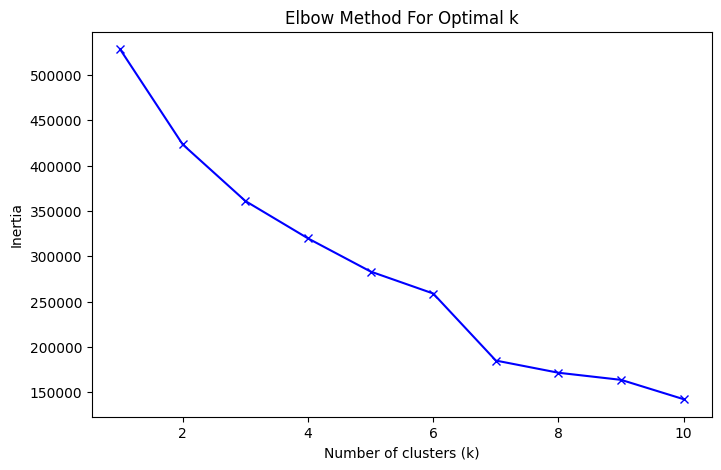

In [64]:
# 엘보우 기법을 사용해 적절한 클러스터 수 찾기
inertia = []
K = range(1, 11)  # 1부터 10까지의 클러스터 수를 테스트

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [65]:
# 최적 클러스터 수
optimal_k = 7

# K-Means 모델 학습
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

# 각 데이터 포인트에 대한 클러스터 할당
merge_df_users_fin['cluster'] = kmeans.labels_

In [66]:
# 클러스터별 빈도수 확인
merge_df_users_fin['cluster'].value_counts()

cluster
0    94370
4     9329
3     1820
1      140
5       20
2        3
6        1
Name: count, dtype: int64

In [67]:
# 클러스터별 통계 확인
cluster_summary = merge_df_users_fin.groupby('cluster')[y_col].mean()
cluster_summary.reset_index()

,cluster,total_engage_rate,net_subscribers_change,averageViewPercentage,revenue_per_view,gross_revenue_per_ad_impression
0,0,0.017104,37.042641,35.398114,1.407242,2.739731
1,1,0.087291,22630.200000,64.881164,0.098894,299.350744
2,2,0.028571,-1.000000,4.223333,1705.123363,0.008333
3,3,0.021243,356.945604,31.063883,2.670372,108.540397
4,4,0.077361,169.226176,30.277042,2.241624,3.608885
5,5,0.031525,-1.450000,14.377500,484.261921,0.223413
6,6,0.009141,-1.000000,15049.760000,0.000000,0.000000


In [68]:
# 클러스터별 y값 빈도수 확인1 - 다중 지표 활용
cluster_summary = merge_df_users_fin.groupby('cluster')['y_label'].value_counts()
cluster_summary

cluster  y_label
0        1          92601
         0           1769
1        0            140
2        0              3
3        0           1621
         1            199
4        1           7598
         0           1731
5        0             20
6        0              1
Name: count, dtype: int64

In [69]:
# 클러스터별 y값 빈도수 확인2 - 개별 지표 종합
cluster_summary = merge_df_users_fin.groupby('cluster')['y_label2'].value_counts()
cluster_summary

cluster  y_label2
0        1           81214
         0           13156
1        0             140
2        0               3
3        0            1820
4        0            6406
         1            2923
5        0              20
6        0               1
Name: count, dtype: int64

In [70]:
# 이상치 군집 확인
merge_df_users_fin[merge_df_users_fin['cluster'].isin([1,2,5,6])]['channel_title'].unique()

array(['임삐나', nan, 'OBL - 온라인 농부, 사자가 되다', '군대위키', '미디하는남자',
       'Jeffreyxking', 'GMENCY 멘시의 마인크래프트', '청어람ARMC'], dtype=object)

In [71]:
# 이상치 탐지 모델 결과 확인
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] >= 40]['youtube_user_id'].unique())]['channel_title'].unique()

array(['임삐나', nan, 'MINLEE 민리', 'OBL - 온라인 농부, 사자가 되다',
       'abbapraise 아바프레이즈', 'Jeffreyxking', '콜드쉽 Coldsheep', 'kiu기우쌤',
       '수빙수tv sooBingsoo', '너굴몬', '코인덕 차트아지', '미니멀영어 Minimal English',
       '日本ジヌ【니혼지누】ー韓国に関する全て', '벽돌할아버지 Brick grandpa', '북토크',
       '나연이즈백 LPGA Na Yeon Choi', '뷰드름 유튜버 인씨', 'MerryMa 메리마',
       "루다의 댄스 연구소 Ruda's Dance Lab", '빅민 GAME', '잼스기타', 'OSSC',
       '뛰뛰빵빵 김옥순', '돈냄새', '키나kkina', '이현우의 MLBTV', '하원장 강동현', '주피코'],
      dtype=object)

## 콘텐츠 데이터 분석

In [33]:
# 최종 콘텐츠 분석 데이터셋
# 환율 적용 - 해당기간 평균환율 : 1322.42
exchange_rate_col = ['estimatedRevenue', 'estimatedAdRevenue', 'estimatedRedPartnerRevenue', 'grossRevenue', 'cpm', 'playbackBasedCpm']
youtube_videos[exchange_rate_col] = youtube_videos[exchange_rate_col] * 1322.42

### 기초통계

In [34]:
# 기초통계
youtube_videos[youtube_videos.columns[20:]].describe()

,cpm,subscribersGained,subscribersLost,monetizedPlaybacks,adImpressions,cardClickRate,cardTeaserClickRate,cardImpressions,cardTeaserImpressions,cardClicks,cardTeaserClicks
count,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06,8.569511e+06
mean,2.281787e+03,1.049081e+00,1.178471e-01,3.611802e+01,4.862698e+01,3.279751e-04,1.479624e-04,3.274866e-03,2.203370e-01,8.963172e-04,1.660888e-03
std,8.802419e+03,2.968088e+01,7.033584e+00,7.577773e+02,1.121002e+03,1.610359e-02,9.179800e-03,3.155597e-01,1.852126e+01,8.120112e-02,1.389403e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.306050e+03,0.000000e+00,0.000000e+00,5.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.280423e+06,2.142100e+04,1.151900e+04,5.134320e+05,6.542410e+05,1.000000e+00,4.000000e+00,3.480000e+02,2.052100e+04,9.400000e+01,1.080000e+02


In [35]:
# 잘못된값 처리
youtube_videos['estimatedRevenue'] = np.where(youtube_videos['estimatedRevenue'] < 0,
                                               youtube_videos['estimatedAdRevenue'] + youtube_videos['estimatedRedPartnerRevenue'],
                                               youtube_videos['estimatedRevenue'])

In [36]:
# 버그로 사용된 수치값 대체
youtube_videos['likes'] = np.where(youtube_videos['likes'] < 0, 0, youtube_videos['likes'])
youtube_videos['dislikes'] = np.where(youtube_videos['dislikes'] < 0, 0, youtube_videos['dislikes'])

### 상관관계

In [37]:
# 상관관계
video_corr_matrix = youtube_videos[youtube_videos.columns[3:]].corr()
video_corr_matrix

,views,redViews,comments,likes,dislikes,shares,estimatedMinutesWatched,estimatedRedMinutesWatched,averageViewDuration,averageViewPercentage,...,subscribersGained,subscribersLost,monetizedPlaybacks,adImpressions,cardClickRate,cardTeaserClickRate,cardImpressions,cardTeaserImpressions,cardClicks,cardTeaserClicks
views,1.000000,0.748574,0.172572,0.931893,0.935864,0.847067,0.797077,0.284345,-0.011406,0.015071,...,0.719996,0.457673,0.080705,0.079120,0.000275,-0.000448,0.004494,0.008788,0.003392,0.005424
redViews,0.748574,1.000000,0.156888,0.614375,0.674459,0.596769,0.633769,0.436308,-0.012772,0.021436,...,0.434398,0.298888,0.207690,0.188833,0.002853,-0.000210,0.014650,0.033207,0.013098,0.018715
comments,0.172572,0.156888,1.000000,0.175911,0.178657,0.169733,0.153305,0.086168,-0.002572,0.004482,...,0.136329,0.094826,0.058566,0.052915,0.010470,0.000961,0.025878,0.038874,0.017999,0.032310
likes,0.931893,0.614375,0.175911,1.000000,0.861688,0.857807,0.736375,0.220131,-0.008103,0.008686,...,0.608671,0.465297,0.012873,0.012491,-0.000337,-0.000348,0.000590,0.001366,0.000389,0.000715
dislikes,0.935864,0.674459,0.178657,0.861688,1.000000,0.781265,0.723926,0.237130,-0.010890,0.013607,...,0.750817,0.430041,0.029062,0.029540,-0.000159,-0.000372,0.001951,0.004208,0.001427,0.002352
shares,0.847067,0.596769,0.169733,0.857807,0.781265,1.000000,0.690062,0.247310,-0.003241,0.008960,...,0.615127,0.431097,0.077805,0.072497,0.002083,-0.000005,0.004398,0.010757,0.004278,0.005071
estimatedMinutesWatched,0.797077,0.633769,0.153305,0.736375,0.723926,0.690062,1.000000,0.675200,0.104230,0.005067,...,0.580522,0.376579,0.482616,0.513620,0.003896,0.000081,0.020150,0.039613,0.017445,0.026030
estimatedRedMinutesWatched,0.284345,0.436308,0.086168,0.220131,0.237130,0.247310,0.675200,1.000000,0.161013,-0.000140,...,0.178035,0.124086,0.556022,0.525052,0.008003,0.000898,0.035002,0.076538,0.033401,0.047375
averageViewDuration,-0.011406,-0.012772,-0.002572,-0.008103,-0.010890,-0.003241,0.104230,0.161013,1.000000,0.061141,...,-0.004473,-0.003233,0.052533,0.048481,0.003050,0.001969,0.002146,0.002472,0.002180,0.002477
averageViewPercentage,0.015071,0.021436,0.004482,0.008686,0.013607,0.008960,0.005067,-0.000140,0.061141,1.000000,...,0.008290,0.003792,-0.008253,-0.007597,-0.003282,-0.002646,-0.001420,-0.001220,-0.001700,-0.001443


### 파생변수

In [38]:
# 파생변수1 - 참여도 관련
youtube_videos['like_rate'] = youtube_videos['likes'] / youtube_videos['views'] ## 좋아요 비율 
youtube_videos['comment_rate'] = youtube_videos['comments'] / youtube_videos['views'] ## 댓글 비율
youtube_videos['share_rate'] = youtube_videos['shares'] / youtube_videos['views'] ## 공유 비율  
youtube_videos['dislike_rate'] = youtube_videos['dislikes'] / youtube_videos['views'] ## 싫어요 비율
youtube_videos['total_engage_rate'] = (youtube_videos['likes'] + youtube_videos['comments'] + youtube_videos['shares'] + youtube_videos['dislikes']) / youtube_videos['views'] ## 총 참여율
youtube_videos['positive_engage_rate'] = (youtube_videos['likes'] + youtube_videos['shares']) / youtube_videos['views'] ## 긍정적 참여율
youtube_videos['comment_to_like_rate'] = youtube_videos['comments'] / youtube_videos['likes'] ## 댓글/좋아요 비율
youtube_videos['like_to_dislike_ratio'] = youtube_videos['likes'] / (youtube_videos['dislikes']) ## 좋아요/싫어요 비율

In [39]:
# 파생변수2 - 구독자 관련
youtube_videos['net_subscribers_change'] = youtube_videos['subscribersGained'] - youtube_videos['subscribersLost'] ## 구독자 순증가
youtube_videos['subscribers_conversion_rate'] = youtube_videos['subscribersGained'] / youtube_videos['views'] ## 구독자 전환율
youtube_videos['subscribers_gained_per_card_click'] = youtube_videos['subscribersGained'] / youtube_videos['cardClicks'] ## 카드 클릭당 구독자 증가
youtube_videos['subscribers_gained_per_playlist_add'] = youtube_videos['subscribersGained'] / youtube_videos['videosAddedToPlaylists'] ## 플레이리스트 추가당 구독자 증가
youtube_videos['card_click_to_subscriber_conversion'] = youtube_videos['cardClickRate'] / youtube_videos['subscribersGained'] ## 카드 클릭률 대비 구독자 전환율
youtube_videos['subscribers_lost_per_playlist_remove'] = youtube_videos['subscribersLost'] / youtube_videos['videosRemovedFromPlaylists'] ## 플레이리스트 제거당 구독자 손실

In [40]:
# 파생변수3 - 수익 관련
youtube_videos['revenue_per_view'] = youtube_videos['estimatedRevenue'] / youtube_videos['views'] ## 조회수당 수익
youtube_videos['revenue_per_red_view'] = youtube_videos['estimatedRevenue'] / youtube_videos['redViews'] ## 프리미엄당 수익
youtube_videos['ad_revenue_rate'] = youtube_videos['estimatedAdRevenue'] / youtube_videos['estimatedRevenue'] ## 광고수익비율
youtube_videos['red_revenue_rate'] = youtube_videos['estimatedRedPartnerRevenue'] / youtube_videos['estimatedRevenue'] ## 프리미엄수익비율
youtube_videos['cpm_to_revenue_ratio'] = youtube_videos['cpm'] / youtube_videos['estimatedRevenue'] ## cpm 대비 수익
youtube_videos['revenue_per_ad_impression'] = youtube_videos['estimatedRevenue'] / youtube_videos['adImpressions'] ## 광고노출당 수익
youtube_videos['playback_based_cpm_rate'] = youtube_videos['playbackBasedCpm'] / youtube_videos['cpm'] ## 재생 기반 수익
youtube_videos['revenue_per_card_click'] = youtube_videos['estimatedRevenue'] / youtube_videos['cardClicks'] ## 카드 클릭당 수익
youtube_videos['revenue_per_playlist_add'] = youtube_videos['estimatedRevenue'] / youtube_videos['videosAddedToPlaylists'] ## 플레이리스트 추가당 수익
youtube_videos['card_click_to_revenue_ratio'] = youtube_videos['cardClickRate'] / youtube_videos['estimatedRevenue'] ## 카드 클릭률 대비 수익 비율
youtube_videos['net_revenue_per_playlist_add'] = (youtube_videos['videosAddedToPlaylists'] - youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['estimatedRevenue'] ## 플레이리스트 순추가당 수익
youtube_videos['ad_revenue_per_card_click'] = youtube_videos['estimatedAdRevenue'] / youtube_videos['cardClicks'] ## 카드 클릭당 광고 수익

In [41]:
# 파생변수4 - 시청 시간 관련
youtube_videos['revenue_per_minute_watched'] = youtube_videos['estimatedRevenue'] / youtube_videos['estimatedMinutesWatched'] ## 시청 시간 당 수익
youtube_videos['revenue_per_minute_watched'] = youtube_videos['estimatedRevenue'] / youtube_videos['estimatedRedMinutesWatched'] ## 프리미엄 이용자 시청 시간 당 수익
youtube_videos['avg_view_duration_rate'] = youtube_videos['averageViewDuration'] / youtube_videos['averageViewPercentage'] ## 평균 시청 시간 비율
youtube_videos['watched_time_rate'] = youtube_videos['averageViewPercentage'] * youtube_videos['estimatedMinutesWatched'] ## 재생 비율 대비 시청 시간
youtube_videos['watched_time_red_rate'] = youtube_videos['averageViewPercentage'] * youtube_videos['estimatedRedMinutesWatched'] ## 재생 비율 대비 프리미엄 이용자 시청 시간
youtube_videos['watched_view_rate'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['views'] ## 조회수당 시청시간
youtube_videos['watched_view_red_rate'] = youtube_videos['estimatedRedMinutesWatched'] / youtube_videos['views'] ## 조회수당 프리미엄 이용자 시청시간
youtube_videos['watch_time_per_card_click'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['cardClicks'] ## 카드 클릭당 시청 시간
youtube_videos['watch_time_per_playlist_add'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['videosAddedToPlaylists'] ## 플레이리스트 추가당 시청 시간
youtube_videos['avg_view_duration_per_card_click'] = youtube_videos['averageViewDuration'] / youtube_videos['cardClicks'] ## 카드 클릭 대비 평균 재생 시간 비율
youtube_videos['watch_time_loss_per_playlist_remove'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['videosRemovedFromPlaylists'] ## 플레이리스트 제거당 시청 시간 손실


In [42]:
# 파생변수5 - 광고 관련
youtube_videos['revenue_per_playback'] = youtube_videos['grossRevenue'] / youtube_videos['monetizedPlaybacks'] ## 1회 광고재생당 수익
youtube_videos['grossRevenue_per_ad_impression'] = youtube_videos['grossRevenue'] / youtube_videos['adImpressions'] ## 1회 광고노출당 총수익
youtube_videos['playback_rate'] = youtube_videos['monetizedPlaybacks'] / youtube_videos['adImpressions'] ## 광고노출 대비 재생율
youtube_videos['unplayback_rate'] = (youtube_videos['adImpressions'] - youtube_videos['monetizedPlaybacks']) / youtube_videos['adImpressions'] ## 광고노출 대비 비재생율
youtube_videos['revenue_per_card_click'] = youtube_videos['grossRevenue'] / youtube_videos['cardClicks'] ## 카드 클릭당 수익
youtube_videos['revenue_per_playlist_add'] = youtube_videos['grossRevenue'] / youtube_videos['videosAddedToPlaylists'] ## 플레이리스트 추가당 수익
youtube_videos['card_click_to_revenue_ratio'] = youtube_videos['cardClickRate'] / youtube_videos['grossRevenue'] ## 카드 클릭률 대비 수익 비율
youtube_videos['net_revenue_per_playlist_add'] = (youtube_videos['videosAddedToPlaylists'] - youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['grossRevenue'] ## 플레이리스트 순추가당 수익
youtube_videos['ad_impressions_per_card_click'] = youtube_videos['adImpressions'] / youtube_videos['cardClicks'] ## 카드 클릭당 광고 노출
youtube_videos['ad_impressions_per_playlist_add'] = youtube_videos['adImpressions'] / youtube_videos['videosAddedToPlaylists'] ## 플레이리스트 추가당 광고 노출
youtube_videos['ad_playbacks_per_card_click'] = youtube_videos['monetizedPlaybacks'] / youtube_videos['cardClicks'] ## 카드 클릭 대비 광고 재생 비율
youtube_videos['ad_playbacks_per_playlist_add'] = youtube_videos['monetizedPlaybacks'] / youtube_videos['videosAddedToPlaylists'] ## 플레이리스트 추가당 광고 재생 비율

In [43]:
# 파생변수6 - 카드 관련
youtube_videos['card_to_teaser_click_rate'] = youtube_videos['cardClickRate'] / youtube_videos['cardTeaserClickRate'] ## 카드 티저 클릭률 대비 카드 클릭률
youtube_videos['card_click_per_impression_rate'] = youtube_videos['cardClicks'] / youtube_videos['cardImpressions'] ## 카드 노출당 클릭 비율
youtube_videos['card_teaser_click_per_impression_rate'] = youtube_videos['cardTeaserClicks'] / youtube_videos['cardTeaserImpressions'] ## 카드 티저 노출당 카드 티저 클릭 비율
youtube_videos['total_card_teaser_click_rate'] = (youtube_videos['cardClicks'] + youtube_videos['cardTeaserClicks']) / (youtube_videos['cardImpressions'] + youtube_videos['cardTeaserImpressions']) ## 카드와 카드 티저의 총 클릭률
youtube_videos['card_conversion_rate'] = youtube_videos['cardClicks'] / youtube_videos['cardTeaserClicks'] ## 카드 클릭 전환율

In [44]:
# 파생변수7 - 비디오 관련
youtube_videos['playlist_addition_rate'] = youtube_videos['videosAddedToPlaylists'] / youtube_videos['views'] ## 플레이리스트 추가 비율
youtube_videos['playlist_removal_rate'] = youtube_videos['videosRemovedFromPlaylists'] / youtube_videos['views'] ## 플레이리스트 제거 비율
youtube_videos['net_playlist_addition_rate'] = (youtube_videos['videosAddedToPlaylists'] - youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['views'] ## 플레이리스트 순추가 비율
youtube_videos['playlist_engagement_rate'] = (youtube_videos['videosAddedToPlaylists'] + youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['views'] ## 플레이리스트 참여도
youtube_videos['playlist_related_revenue_rate'] = youtube_videos['estimatedRevenue'] / youtube_videos['videosAddedToPlaylists'] ## 플레이리스트 추가 당 순수익

In [45]:
# null값 대체
youtube_videos = youtube_videos.fillna(0) ## NaN
youtube_videos = youtube_videos.replace([np.inf, -np.inf], 0) ## inf

### 시계열 확인
- Looker Studio 활용

In [ ]:
# 'date' 컬럼을 datetime 형식으로 변환
merge_df_users_fin['date'] = pd.to_datetime(merge_df_users_fin['date'])

# 주(week) 컬럼 생성 (ISO 주 번호 기준)
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].dt.isocalendar().week
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_week'].astype(str)
merge_df_users_fin['date_week'] = pd.to_datetime(merge_df_users_fin['date_week'] + '-1', format='%Y-%W-%w') ## looker studio 날짜 형식 위해 주마다 월요일 날짜로 변경
merge_df_users_fin['date_week'] = merge_df_users_fin['date_week'].astype(str)

# 월(month) 컬럼 생성
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].dt.month
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_month'].fillna(0).astype(int).astype(str)
merge_df_users_fin['date_month'] = np.where(merge_df_users_fin['date_month']=='NaT-0','',merge_df_users_fin['date_month'])

# 분기(quarter) 컬럼 생성
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].dt.to_period('Q').dt.quarter
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_quarter'].fillna(0).astype(str)
merge_df_users_fin['date_quarter'] = np.where(merge_df_users_fin['date_quarter']=='NaT--1','',merge_df_users_fin['date_quarter'])

In [ ]:
merge_df_users_looker = merge_df_users_fin[['youtube_user_id','date','date_week','date_month','date_quarter','viewCount','subscriberCount','videoCount',
                                            'views','estimated_revenue','subscribers_count','estimatedMinutesWatched','averageViewDuration',
                                            'total_engage_rate','net_subscribers_change','averageViewPercentage','revenue_per_view',
                                            'female_viewer_rate', 'male_viewer_rate', 'youth_viewer_rate', 'adult_viewer_rate', 'older_viewer_rate']]

In [ ]:
# merge_df_users_looker.to_csv('C:/py_src/awake/data/merge_df_users_looker.csv', encoding='utf-8-sig', index=False)

### y값 설정

#### 중요 지표 표준화

In [50]:
# y값 활용 지표
y_col = ['total_engage_rate', 'net_subscribers_change', 'averageViewPercentage', 'revenue_per_view', 'grossRevenue_per_ad_impression','total_card_teaser_click_rate','playlist_engagement_rate'] ## null값은 views가 0인 데이터

In [51]:
# null값 대체
youtube_videos[y_col] = youtube_videos[y_col].fillna(0) ## NaN
youtube_videos[y_col] = youtube_videos[y_col].replace([np.inf, -np.inf], 0) ## inf

In [52]:
# 표준화 (Standard Scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(youtube_videos[y_col])

#### 다중 지표 결합

In [53]:
# Isolation Forest 모델 학습
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 이상치 비율 설정
iso_forest.fit(scaled_features)

# 이상치 점수 계산
anomaly_scores = iso_forest.decision_function(scaled_features)

In [54]:
# 임계값 설정
threshold = np.percentile(anomaly_scores, 5) ## 이상치 점수가 작을수록 이상치에 가깝다고 판단하는데, 5번째 백분위수가 (-)로 바뀌는 포인트

# y값 라벨링 (이상치이면 0, 그렇지 않으면 1)
youtube_videos['y_label'] = np.where(anomaly_scores < threshold, 0, 1)

In [55]:
# 전체 데이터 y값 빈도 확인
youtube_videos['y_label'].value_counts()

y_label
1    8141038
0     428473
Name: count, dtype: int64

In [56]:
# youtube_videos.to_csv('C:/py_src/awake/data/youtube_videos_eda.csv', encoding='utf-8-sig', index=False)

In [22]:
# 계정별 y값 빈도 데이터
youtube_videos.groupby('youtube_user_id')['y_label'].value_counts().reset_index()

,youtube_user_id,y_label,count
0,627cb611aa6f212355e0b617,1,15241
1,627cb611aa6f212355e0b617,0,164
2,627f59ccaa39226247c60b01,1,8047
3,627f59ccaa39226247c60b01,0,507
4,6287228afb15712a8cb931d7,1,5131
...,...,...,...
493,65f7b17ed8da110bb0733b7b,0,86
494,65fecf7ed8da110bb0736199,1,8649
495,65fecf7ed8da110bb0736199,0,150
496,66230ee6d8da110bb0744b2d,1,3344


In [47]:
# 콘텐츠별 y값 빈도 데이터
y_result_df = youtube_videos.groupby('video')['y_label'].value_counts().reset_index()

# 콘텐츠별 일일 측정 데이터 수
video_cnt_df = youtube_videos.groupby('video')['end_date'].count().reset_index()

y_result_df = pd.merge(y_result_df,video_cnt_df,how='left',on='video')
y_result_df = y_result_df.rename(columns={'end_date':'total_count'})
y_result_df['standard_cnt'] = round(y_result_df['total_count'] * 0.1) ## 비디오별 일일 전체 데이터 중 이상치 데이터가 10% 이상
y_result_df['standard_cnt'] = y_result_df['standard_cnt'].astype(int)

y_result_df

,video,y_label,count,total_count,standard_cnt
0,--0HSDH6J7o,1,15,15,2
1,--0XOlJ3Lw4,1,397,399,40
2,--0XOlJ3Lw4,0,2,399,40
3,--7sZPRc1H4,1,31,32,3
4,--7sZPRc1H4,0,1,32,3
...,...,...,...,...,...
135441,zzlQiqh04eE,1,21,21,2
135442,zzwBOCOq5YI,1,308,342,34
135443,zzwBOCOq5YI,0,34,342,34
135444,zzza6bbJnMI,1,201,203,20


In [85]:
# 이상치 1개라도 있는 콘텐츠 확인
y_result_df[y_result_df['y_label']==0]['video']

2         --0XOlJ3Lw4
4         --7sZPRc1H4
6         --8Bucaa0Go
8         --FZnuz9-JQ
10        --FknkrtRXg
             ...     
135434    zzWuUVocjCI
135436    zz_dWlZVXJw
135438    zz_p_CzUMvw
135443    zzwBOCOq5YI
135445    zzza6bbJnMI
Name: video, Length: 49222, dtype: object

In [48]:
# 계정별 일일데이터의 10% 이상 이상치 데이터
video_outlier_df = y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] > y_result_df[y_result_df['y_label']==0]['standard_cnt']].reset_index(drop=True)
video_outlier_df

,video,y_label,count,total_count,standard_cnt
0,--8Bucaa0Go,0,12,97,10
1,--stoDeuI_4,0,2,8,1
2,-0IyJ6nzgSg,0,18,87,9
3,-0JNe3se7JM,0,27,254,25
4,-0csgxlNcSc,0,14,68,7
...,...,...,...,...,...
11164,zyf0BOV1V1s,0,9,58,6
11165,zyjbDedYZB8,0,1,5,0
11166,zypZyGqg9ZY,0,1,2,0
11167,zyyDUlfD4jg,0,7,48,5


In [55]:
# 이상치 중 데이터 부족으로 판단 어려운 것 제거 후 최종 이상치 콘텐츠
video_outlier_fin = video_outlier_df[video_outlier_df['standard_cnt']!=0]['video'].unique()

In [62]:
# 계정별 콘텐츠 수 확인
youtube_videos.groupby('youtube_user_id')['video'].count().reset_index()

,youtube_user_id,video
0,627cb611aa6f212355e0b617,15405
1,627f59ccaa39226247c60b01,8554
2,6287228afb15712a8cb931d7,5179
3,6287229efb15712a8cb93225,79977
4,628722c8fb15712a8cb9326e,34783
...,...,...
244,65cc401305bf1c0baa425146,12038
245,65e7b773d8da110bb072e2b5,6196
246,65f7b17ed8da110bb0733b7b,2527
247,65fecf7ed8da110bb0736199,8799


In [63]:
# 계정별 이상치 콘텐츠 수 확인
youtube_videos[youtube_videos['video'].isin(video_outlier_fin)].groupby('youtube_user_id')['video'].count().reset_index()

,youtube_user_id,video
0,627cb611aa6f212355e0b617,147
1,627f59ccaa39226247c60b01,700
2,6287229efb15712a8cb93225,1251
3,628722c8fb15712a8cb9326e,2052
4,62872317fb15712a8cb932e9,6734
...,...,...
227,65cc401305bf1c0baa425146,5035
228,65e7b773d8da110bb072e2b5,641
229,65f7b17ed8da110bb0733b7b,41
230,65fecf7ed8da110bb0736199,31


In [65]:
# 계정별 이상치 콘텐츠 결과 데이터셋
result_contents_df = pd.merge(youtube_videos.groupby('youtube_user_id')['video'].count().reset_index(),
                              youtube_videos[youtube_videos['video'].isin(video_outlier_fin)].groupby('youtube_user_id')['video'].count().reset_index(),
                              how='left',on='youtube_user_id')
result_contents_df = result_contents_df[~result_contents_df['video_y'].isnull()].reset_index(drop=True)

In [76]:
# 이상치 콘텐츠를 많이 갖고 있는 계정
result_contents_df[(result_contents_df['video_y'] / result_contents_df['video_x']) > 0.1]

,youtube_user_id,video_x,video_y
4,62872317fb15712a8cb932e9,43332,6734.0
6,62872370fb15712a8cb93337,36478,5218.0
7,6287239cfb15712a8cb93368,22235,3358.0
18,62873efffb15712a8cb941a2,33547,6711.0
27,629c6ab9eaf5732d6deb9186,44321,19038.0
...,...,...,...
221,6551daa41120b40b442abd16,4034,449.0
222,65a3f25864b4250ba696579a,16318,6421.0
225,65bbb4a905bf1c0baa41e95c,10565,3373.0
227,65cc401305bf1c0baa425146,12038,5035.0


In [80]:
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(result_contents_df[(result_contents_df['video_y'] / result_contents_df['video_x']) > 0.1]['youtube_user_id'])]['channel_title'].unique()

array(['Ella', nan, 'hyeppening 혜프닝', 'KIMBEE 킴비', '지니원장의피부톡톡', '흙회장',
       'Mind Patting마음토닥', '배우GO', 'MINLEE 민리', '시골낭만아재', '황나겸', '래아TV',
       'sa lly', 'SATUR 세터업', '이숲soop', '래띠 LAETI',
       'OBL - 온라인 농부, 사자가 되다', '시리얼 Sireal', '서유 SEOYU DANCE',
       'ORlGN 오리진', 'abbapraise 아바프레이즈', '잉툰TV- 만화로 쉽게 영어배우자',
       '모하지연 MOHAJIYEON', '부반TV_부에 반하다', '김두부', '라나제이베이킹Lana J', '미디하는남자',
       'Jeffreyxking', '바라던 바다 BADACHANNEL', '월텍남 - 월스트리트 테크남', '비됴클래스',
       '만능혁키', 'Dalhae달달해', '어웨이커 | 크리에이터 이코노미',
       '석시원 커플 SeokSiWon Couple', '태권민국_Captain Master', '너굴몬', '디지털생활제안',
       '미니멀영어 Minimal English', '청어람ARMC', 'Ood 오드', '황헬린 탈출기', '보미름',
       '비제TV', '소피요가 Sophie Yoga', '정가거부', '중년독수리의 대리여행', '북토크',
       '태다린tae_darin', '요니의 응원 yoni', '나연이즈백 LPGA Na Yeon Choi',
       '니들needle', '그롬마쉬TV', '복지다있소', '세계여행 테리로그 TERRYLOG', 'AllaproTV',
       '스타트업잡스', '청도시네마', '와뷰티TV | Wow Beauty ASMR', '김퍼프PUFF', '쿜쿜쿜',
       '법무법인 슈가스퀘어', '닷츠 DOTS', '돈냄새', '에피코딩', '키나kkina', '이현

#### 군집분석

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

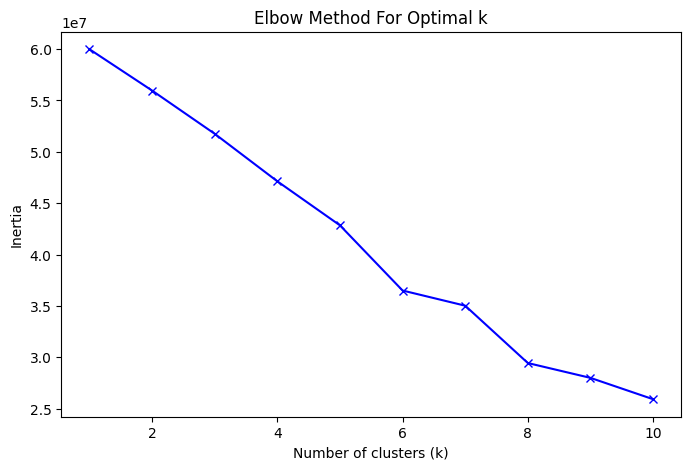

In [90]:
# 엘보우 기법을 사용해 적절한 클러스터 수 찾기
inertia = []
K = range(1, 11)  # 1부터 10까지의 클러스터 수를 테스트

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [96]:
# 최적 클러스터 수
optimal_k = 8

# K-Means 모델 학습
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

# 각 데이터 포인트에 대한 클러스터 할당
youtube_videos['cluster'] = kmeans.labels_

In [97]:
# 클러스터별 빈도수 확인
youtube_videos['cluster'].value_counts()

cluster
4    8447882
0     117581
3       2095
1        915
7        723
6        304
5          8
2          3
Name: count, dtype: int64

In [98]:
# 클러스터별 통계 확인
cluster_summary = youtube_videos.groupby('cluster')[y_col].mean()
cluster_summary.reset_index()

,cluster,total_engage_rate,net_subscribers_change,averageViewPercentage,revenue_per_view,grossRevenue_per_ad_impression,total_card_teaser_click_rate,playlist_engagement_rate
0,0,0.637679,0.073073,58.979562,1.691165,1.697127,0.000004,0.060089
1,1,0.084833,1726.257923,80.653071,0.081326,0.048998,0.000004,0.001217
2,2,0.000000,0.000000,44.130000,0.000000,0.000000,0.000000,677.833333
3,3,0.023175,0.943198,32.828644,2.863418,6.823739,0.461026,0.024624
4,4,0.013488,0.756414,49.290731,1.413274,2.250632,0.000045,0.018517
5,5,0.000000,0.000000,13.711250,19312.125772,0.000000,0.000000,0.000000
6,6,0.033639,0.009868,10960.412401,0.070652,0.021750,0.000000,0.006829
7,7,0.025967,0.033195,33.770401,1162.176524,452.020859,0.000000,0.031302


In [99]:
# 클러스터별 y값 빈도수 확인1 - 다중 지표 활용
cluster_summary = youtube_videos.groupby('cluster')['y_label'].value_counts()
cluster_summary

cluster  y_label
0        0            83815
         1            33766
1        0              915
2        0                3
3        1             1725
         0              370
4        1          8105547
         0           342335
5        0                8
6        0              304
7        0              723
Name: count, dtype: int64

In [108]:
# 이상치 군집 확인
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(youtube_videos[youtube_videos['cluster'].isin([1,2,5,6,7])]['youtube_user_id'].unique())]['channel_title'].unique()

array(['세남자 물고기', nan, '띠혜 ddihye', '소리미의 신화방송', 'Ella', '찌늉',
       'hyeppening 혜프닝', 'KIMBEE 킴비', '름쿠 ᴘʟᴀʏʟɪꜱᴛ', '임삐나', '나는 불독',
       '바른걸음연구소', '임퓨의 비트메이킹 클래스', '차박씬', '지니원장의피부톡톡', '오늘도희다 HEEDA',
       '낭만아저씨코디TV', 'Kevin Factory케빈팩토리', 'assesta', 'JinBlog 진블로그',
       '흙회장', '유익한 균튜버', '차세이CHASEYi', 'Mind Patting마음토닥', '1분뉴스', '배우GO',
       'the sence', 'MINLEE 민리', '시골낭만아재', '황나겸', '성한준', '다먹어라이언',
       '하부유튜브 Minor / (Lower) YouTube', 'Seol-A 라이더 설아', 'SATUR 세터업',
       '수집의 수집', '굥플레이스 맛집투어', '이숲soop', '래띠 LAETI',
       'OBL - 온라인 농부, 사자가 되다', '시리얼 Sireal', '서유 SEOYU DANCE',
       'abbapraise 아바프레이즈', '윈플즈TV', '채찍단', '잉툰TV- 만화로 쉽게 영어배우자',
       '라이프에이치 Life.H', '채림처럼firstcherry', '오엔티엘 패션 / ONTL FASHION',
       '드론브이로그 DroneVlog', '에디레일 Eddy Rails', '모하지연 MOHAJIYEON',
       '시현하다 RECORDERS', '데일리 슬슬', '오토컨테이너 스튜디오', '부반TV_부에 반하다',
       'Mein 미인', '라나제이베이킹Lana J', '군대위키', '미디하는남자', 'Jeffreyxking',
       '고기,요정 MeatPixie', '유경몬', '콜드쉽 Coldsheep', '여정을떠난여정', '찌수연',

In [109]:
# 이상치 탐지 모델 결과 확인
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(result_contents_df[(result_contents_df['video_y'] / result_contents_df['video_x']) > 0.1]['youtube_user_id'])]['channel_title'].unique()

array(['Ella', nan, 'hyeppening 혜프닝', 'KIMBEE 킴비', '지니원장의피부톡톡', '흙회장',
       'Mind Patting마음토닥', '배우GO', 'MINLEE 민리', '시골낭만아재', '황나겸', '래아TV',
       'sa lly', 'SATUR 세터업', '이숲soop', '래띠 LAETI',
       'OBL - 온라인 농부, 사자가 되다', '시리얼 Sireal', '서유 SEOYU DANCE',
       'ORlGN 오리진', 'abbapraise 아바프레이즈', '잉툰TV- 만화로 쉽게 영어배우자',
       '모하지연 MOHAJIYEON', '부반TV_부에 반하다', '김두부', '라나제이베이킹Lana J', '미디하는남자',
       'Jeffreyxking', '바라던 바다 BADACHANNEL', '월텍남 - 월스트리트 테크남', '비됴클래스',
       '만능혁키', 'Dalhae달달해', '어웨이커 | 크리에이터 이코노미',
       '석시원 커플 SeokSiWon Couple', '태권민국_Captain Master', '너굴몬', '디지털생활제안',
       '미니멀영어 Minimal English', '청어람ARMC', 'Ood 오드', '황헬린 탈출기', '보미름',
       '비제TV', '소피요가 Sophie Yoga', '정가거부', '중년독수리의 대리여행', '북토크',
       '태다린tae_darin', '요니의 응원 yoni', '나연이즈백 LPGA Na Yeon Choi',
       '니들needle', '그롬마쉬TV', '복지다있소', '세계여행 테리로그 TERRYLOG', 'AllaproTV',
       '스타트업잡스', '청도시네마', '와뷰티TV | Wow Beauty ASMR', '김퍼프PUFF', '쿜쿜쿜',
       '법무법인 슈가스퀘어', '닷츠 DOTS', '돈냄새', '에피코딩', '키나kkina', '이현